<a href="https://colab.research.google.com/github/nv-hiep/object_detection/blob/main/Step4_Multi_class_object_detection_and_bounding_box_regression_with_Keras%2C_TensorFlow%2C_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class object detection and bounding box regression with Keras, TensorFlow, and Deep Learning

To build a Multi-class object detector with Keras and TensorFlow:

1. Use VGG16 model and remove the fully-connected (FC) layer head.

2. Construct a new FC layer head with two branches:
 

*   Branch 1: A series of FC layers that end with a layer with (1) four neurons, corresponding to the top-left and bottom-right (x, y)-coordinates of the predicted bounding box and (2) a sigmoid activation function, such that the output of each four neurons lies in the range [0, 1]. This branch is responsible for bounding box predictions.
*   Branch 2: Another series of FC layers, but this one with a softmax classifier at the end. This branch is in charge of making class label predictions.

3. Place the new FC layer head (with the two branches) on top of the VGG16 base.
4. Fine-tune the entire network for end-to-end object detection

A multi-class object detector needs a fully-connected layer head with two branches:

1. A regression layer set, just like in the single-class object detection case
2. An additional layer set, this one with a softmax classifier used to predict class labels

Used together, a single forward pass of our multi-class object detector will result in:

1. The predicted bounding box coordinates of the object in the image.

2. The predicted class label of the object in the image.

# Connect and authorize google drive with google colab:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!ls

/content/gdrive/My Drive/Colab Notebooks/object_detection
 data
 logo.png
 model
 plots
'Step1_Bounding box with OpenCV.ipynb'
'step2_Bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
'Step3 Prepare data for Multi-class object detection.ipynb'
'Step4 Multi-class object detection and bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
 test


# Libraries

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import glob
import time
import csv
import cv2

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches

from PIL import Image
from scipy.io import loadmat


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

from google.colab.patches import cv2_imshow

In [5]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import pickle

#1. Caltech 101 dataset

## 1.1 Data directories

In [6]:
# APP_PATH = !pwd
APP_PATH  = '/content/gdrive/My Drive/Colab Notebooks/object_detection'
DAT_DIR   = os.path.join(APP_PATH, 'data')
PREP_DIR  = os.path.join(DAT_DIR, 'prep')
DATA_PATH = os.path.join(DAT_DIR, '101_ObjectCategories')
ANN_PATH  = os.path.join(DAT_DIR, 'Annotations') 

print('Project path: ', APP_PATH)
print('Data path: ', DATA_PATH)
print('Annotation path: ', ANN_PATH)

Project path:  /content/gdrive/My Drive/Colab Notebooks/object_detection
Data path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories
Annotation path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations


In [7]:
if not os.path.exists(PREP_DIR):
  os.makedirs(PREP_DIR)

In [8]:
MODEL_PATH = os.path.join(APP_PATH, 'model')
PLOT_PATH = os.path.join(APP_PATH, 'plots')
TEST_PATH = os.path.join(APP_PATH, 'test')

print('Model path: ', MODEL_PATH)
print('Plot path: ', PLOT_PATH)
print('Test path: ', TEST_PATH)

if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(PLOT_PATH):
  os.makedirs(PLOT_PATH)

if not os.path.exists(TEST_PATH):
  os.makedirs(TEST_PATH)

Model path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/model
Plot path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/plots
Test path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/test


##1.2 All labels and annotations

In [9]:
# subdirectories in 101_ObjectCategories
dirs   = glob.glob( os.path.join(DATA_PATH, '*') )
labels = [x.split('/')[-1] for x in dirs]
print('Number of labels: ', len(labels))
print('Some examples: ', labels)

Number of labels:  102
Some examples:  ['bonsai', 'anchor', 'barrel', 'beaver', 'bass', 'BACKGROUND_Google', 'airplanes', 'ant', 'accordion', 'binocular', 'brontosaurus', 'butterfly', 'brain', 'cellphone', 'chair', 'car_side', 'cannon', 'ceiling_fan', 'buddha', 'camera', 'dollar_bill', 'dalmatian', 'chandelier', 'cup', 'cougar_body', 'crocodile', 'crab', 'cougar_face', 'crayfish', 'crocodile_head', 'Faces_easy', 'ferry', 'dolphin', 'Faces', 'euphonium', 'emu', 'electric_guitar', 'elephant', 'ewer', 'dragonfly', 'garfield', 'headphone', 'grand_piano', 'helicopter', 'flamingo', 'gramophone', 'hedgehog', 'hawksbill', 'flamingo_head', 'gerenuk', 'ibis', 'joshua_tree', 'lobster', 'kangaroo', 'inline_skate', 'lamp', 'ketch', 'llama', 'Leopards', 'laptop', 'Motorbikes', 'metronome', 'okapi', 'nautilus', 'mandolin', 'mayfly', 'lotus', 'octopus', 'menorah', 'minaret', 'saxophone', 'pagoda', 'panda', 'pizza', 'rhino', 'pigeon', 'rooster', 'revolver', 'pyramid', 'platypus', 'schooner', 'stop_sign

In [10]:
# subdirectories in Annotations
dirs = glob.glob( os.path.join(ANN_PATH, '*') )
anns = [x.split('/')[-1] for x in dirs]
print('Number of Annotations: ', len(anns))
print('Some examples: ', anns)

Number of Annotations:  106
Some examples:  ['progress.mat', 'README', 'README~', 'FeatureDetectionQuality.mat', 'check_progress.mat', 'Airplanes_Side_2', 'ant', 'brain', 'anchor', 'beaver', 'bass', 'binocular', 'bonsai', 'accordion', 'barrel', 'chair', 'butterfly', 'cellphone', 'camera', 'buddha', 'car_side', 'ceiling_fan', 'chandelier', 'cannon', 'brontosaurus', 'cougar_face', 'cougar_body', 'dolphin', 'crocodile', 'dalmatian', 'crab', 'cup', 'dollar_bill', 'crocodile_head', 'crayfish', 'flamingo', 'electric_guitar', 'Faces_2', 'ferry', 'dragonfly', 'ewer', 'Faces_3', 'elephant', 'euphonium', 'emu', 'helicopter', 'gerenuk', 'headphone', 'flamingo_head', 'gramophone', 'hawksbill', 'grand_piano', 'ibis', 'garfield', 'hedgehog', 'llama', 'joshua_tree', 'ketch', 'lotus', 'inline_skate', 'lobster', 'lamp', 'Leopards', 'laptop', 'kangaroo', 'octopus', 'mayfly', 'minaret', 'Motorbikes_16', 'pagoda', 'metronome', 'nautilus', 'okapi', 'menorah', 'mandolin', 'rhino', 'pigeon', 'pizza', 'schoon

Directories for images and annotations

In [69]:
imgs_   = ['Motorbikes', 'airplanes', 'bonsai', 'Faces', 'kangaroo']
annots_ = ['Motorbikes_16', 'Airplanes_Side_2', 'bonsai', 'Faces_2', 'kangaroo']

#2. Load annotations

In [12]:
csv_path  = os.path.join(PREP_DIR, '*.csv')
csv_files = glob.glob( csv_path )
csv_files

['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Motorbikes.csv',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_airplanes.csv',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_bonsai.csv',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Faces.csv',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_kangaroo.csv']

All classes available

In [13]:
classes = [x.split('/')[-1].replace('data_', '').replace('.csv','').lower() for x in csv_files]
n_classes = len(classes)
print('Number of classes: ', n_classes)
print('All classes: ', classes)

Number of classes:  5
All classes:  ['motorbikes', 'airplanes', 'bonsai', 'faces', 'kangaroo']


In [14]:
df = []
for xf in csv_files:
  df.append( pd.read_csv(xf) )

df = pd.concat(df)
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,motorbikes,image_0026.jpg,annotation_0026.mat,_0026,"(180, 275, 3)",180.0,275.0,36.0,240.0,27.0,158.0,"[0.131, 0.873, 0.15, 0.878]"
1,motorbikes,image_0020.jpg,annotation_0020.mat,_0020,"(159, 263, 3)",159.0,263.0,31.0,234.0,17.0,139.0,"[0.118, 0.89, 0.107, 0.874]"
2,motorbikes,image_0024.jpg,annotation_0024.mat,_0024,"(153, 263, 3)",153.0,263.0,33.0,230.0,25.0,133.0,"[0.125, 0.875, 0.163, 0.869]"
3,motorbikes,image_0031.jpg,annotation_0031.mat,_0031,"(150, 265, 3)",150.0,265.0,30.0,233.0,15.0,129.0,"[0.113, 0.879, 0.1, 0.86]"
4,motorbikes,image_0010.jpg,annotation_0010.mat,_0010,"(148, 263, 3)",148.0,263.0,32.0,233.0,18.0,127.0,"[0.122, 0.886, 0.122, 0.858]"


In [15]:
df.describe

<bound method NDFrame.describe of          class        img_file  ...  y_end                       targets
0   motorbikes  image_0026.jpg  ...  158.0   [0.131, 0.873, 0.15, 0.878]
1   motorbikes  image_0020.jpg  ...  139.0   [0.118, 0.89, 0.107, 0.874]
2   motorbikes  image_0024.jpg  ...  133.0  [0.125, 0.875, 0.163, 0.869]
3   motorbikes  image_0031.jpg  ...  129.0     [0.113, 0.879, 0.1, 0.86]
4   motorbikes  image_0010.jpg  ...  127.0  [0.122, 0.886, 0.122, 0.858]
..         ...             ...  ...    ...                           ...
81    kangaroo  image_0069.jpg  ...  218.0   [0.017, 0.71, 0.023, 0.991]
82    kangaroo  image_0085.jpg  ...  217.0  [0.027, 0.807, 0.238, 0.831]
83    kangaroo  image_0021.jpg  ...  194.0   [0.007, 0.89, 0.027, 0.862]
84    kangaroo  image_0086.jpg  ...  202.0   [0.047, 0.803, 0.083, 0.99]
85    kangaroo  image_0083.jpg  ...  189.0  [0.027, 0.863, 0.066, 0.784]

[2247 rows x 12 columns]>

In [16]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [17]:
df['bbox'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [18]:
df.drop(['targets'], axis=1, inplace=True)

In [19]:
bboxes    = np.array( [x for x in df.bbox], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [20]:
print('bboxes targets.shape: ', bboxes.shape)
bboxes[:3]

bboxes targets.shape:  (2247, 4)


array([[0.131, 0.873, 0.15 , 0.878],
       [0.118, 0.89 , 0.107, 0.874],
       [0.125, 0.875, 0.163, 0.869]], dtype=float32)

In [21]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (2247,)


array(['image_0026.jpg', 'image_0020.jpg', 'image_0024.jpg'], dtype='<U14')

In [22]:
labels = df['class'].to_numpy()
print('Labels: ', labels.shape)
print('All labels: ', np.unique(labels))
labels[:3]

Labels:  (2247,)
All labels:  ['airplanes' 'bonsai' 'faces' 'kangaroo' 'motorbikes']


array(['motorbikes', 'motorbikes', 'motorbikes'], dtype=object)

#3. Load image data from numpy files

In [23]:
npy_path  = os.path.join(PREP_DIR, '*.npy')
npy_files = glob.glob( npy_path )
npy_files

['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Motorbikes.npy',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_airplanes.npy',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_bonsai.npy',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Faces.npy',
 '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_kangaroo.npy']

In [24]:
X_data = []
for xf in npy_files:
  X_data.append( np.load(xf) )

X_data = np.concatenate( X_data, axis=0)
X_data.shape

(2247, 224, 224, 3)

In [25]:
print('Number of images: ', len(X_data))
print('Shape of a sample image: ', X_data[0].shape)

Number of images:  2247
Shape of a sample image:  (224, 224, 3)


In [26]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
X_data = np.array(X_data, dtype='float32') / 255.

In [27]:
X_data.shape

(2247, 224, 224, 3)

#4. Data preprocessing

In [28]:
# perform one-hot encoding on the labels
lb     = LabelBinarizer()
labels = lb.fit_transform(labels)
print('labels.shape', labels.shape)
labels[:3]

labels.shape (2247, 5)


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [52]:
print('Label of lb: ', lb.classes_)

Label of lb:  ['airplanes' 'bonsai' 'faces' 'kangaroo' 'motorbikes']


In [29]:
split = train_test_split(X_data, labels, bboxes, filenames, test_size=0.15,	random_state=42)

In [30]:
len(split)

8

In [31]:
# unpack the data split
(X_train_full, X_test) = split[:2]
(label_train_full, label_test) = split[2:4]
(bbox_train_full, bbox_test) = split[4:6]
(file_train, file_test) = split[6:]

In [32]:
print('X_train_full shape: ', X_train_full.shape)
print('X_test shape:', X_test.shape)

X_train_full shape:  (1909, 224, 224, 3)
X_test shape: (338, 224, 224, 3)


In [33]:
print('Label_train_full shape: ', label_train_full.shape)
print('Label_test shape:', label_test.shape)

Label_train_full shape:  (1909, 5)
Label_test shape: (338, 5)


In [34]:
print('Bbox_train_full shape: ', bbox_train_full.shape)
print('Bbox_test shape:', bbox_test.shape)

Bbox_train_full shape:  (1909, 4)
Bbox_test shape: (338, 4)


In [35]:
print('File_train shape: ', file_train.shape)
print('File_test shape:', file_test.shape)

File_train shape:  (1909,)
File_test shape: (338,)


In [36]:
X_train, X_valid, label_train, label_valid, bbox_train, bbox_valid = train_test_split(X_train_full, label_train_full, bbox_train_full, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_valid shape', X_valid.shape)
print('Label_train shape: ', label_train.shape)
print('Label_valid shape', label_valid.shape)
print('Bbox_train shape: ', bbox_train.shape)
print('Bbox_valid shape', bbox_valid.shape)

X_train shape:  (1527, 224, 224, 3)
X_valid shape (382, 224, 224, 3)
Label_train shape:  (1527, 5)
Label_valid shape (382, 5)
Bbox_train shape:  (1527, 4)
Bbox_valid shape (382, 4)


#5. Model

##5.1 Build model

Use VGG16 model for fine-tuning:

In [37]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR    = 1.e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [38]:
# load the VGG16 model, ensuring the head FC layers are left off
# Note: the input-size of VGG16 = (224, 224, 3)
base_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the training process
base_vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = base_vgg.output
flatten = Flatten()(flatten)

In [39]:
'''
Initialization	Activation function
Glorot          None, tanh, logistic, softmax
He              ReLU and variants
LeCun           SELU
'''

# construct a fully-connected layer header to output
# the predicted bounding box coordinates: ['x_start_ratio', 'x_end_ratio', 'y_start_ratio', 'y_end_ratio']
bbox_head = Dense(units=128, activation='relu', kernel_initializer='he_uniform')(flatten)
bbox_head = Dense(units=64, activation='relu', kernel_initializer='he_uniform')(bbox_head)
bbox_head = Dense(units=32, activation='relu', kernel_initializer='he_uniform')(bbox_head)
bbox_head = Dense(units=4, activation='sigmoid', name='bounding_box')(bbox_head)

In [40]:
# construct a second fully-connected layer head to predict the class label
clf_head = Dense(units=521, activation='relu', kernel_initializer='he_uniform')(flatten)
clf_head = Dropout(0.5)(clf_head)
clf_head = Dense(units=256, activation='relu', kernel_initializer='he_uniform')(clf_head)
clf_head = Dropout(0.5)(clf_head)
clf_head = Dense(units=n_classes, activation='softmax', name='class_label')(clf_head)

In [41]:
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=[base_vgg.input], outputs=[bbox_head, clf_head])

In [42]:
# initialize the optimizer, compile the model, and show the model # summary
optimizer = Adam(lr=INIT_LR)
model.compile(loss=['mse', 'categorical_crossentropy'], optimizer=optimizer, metrics=['accuracy'], loss_weights=[1., 1.])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

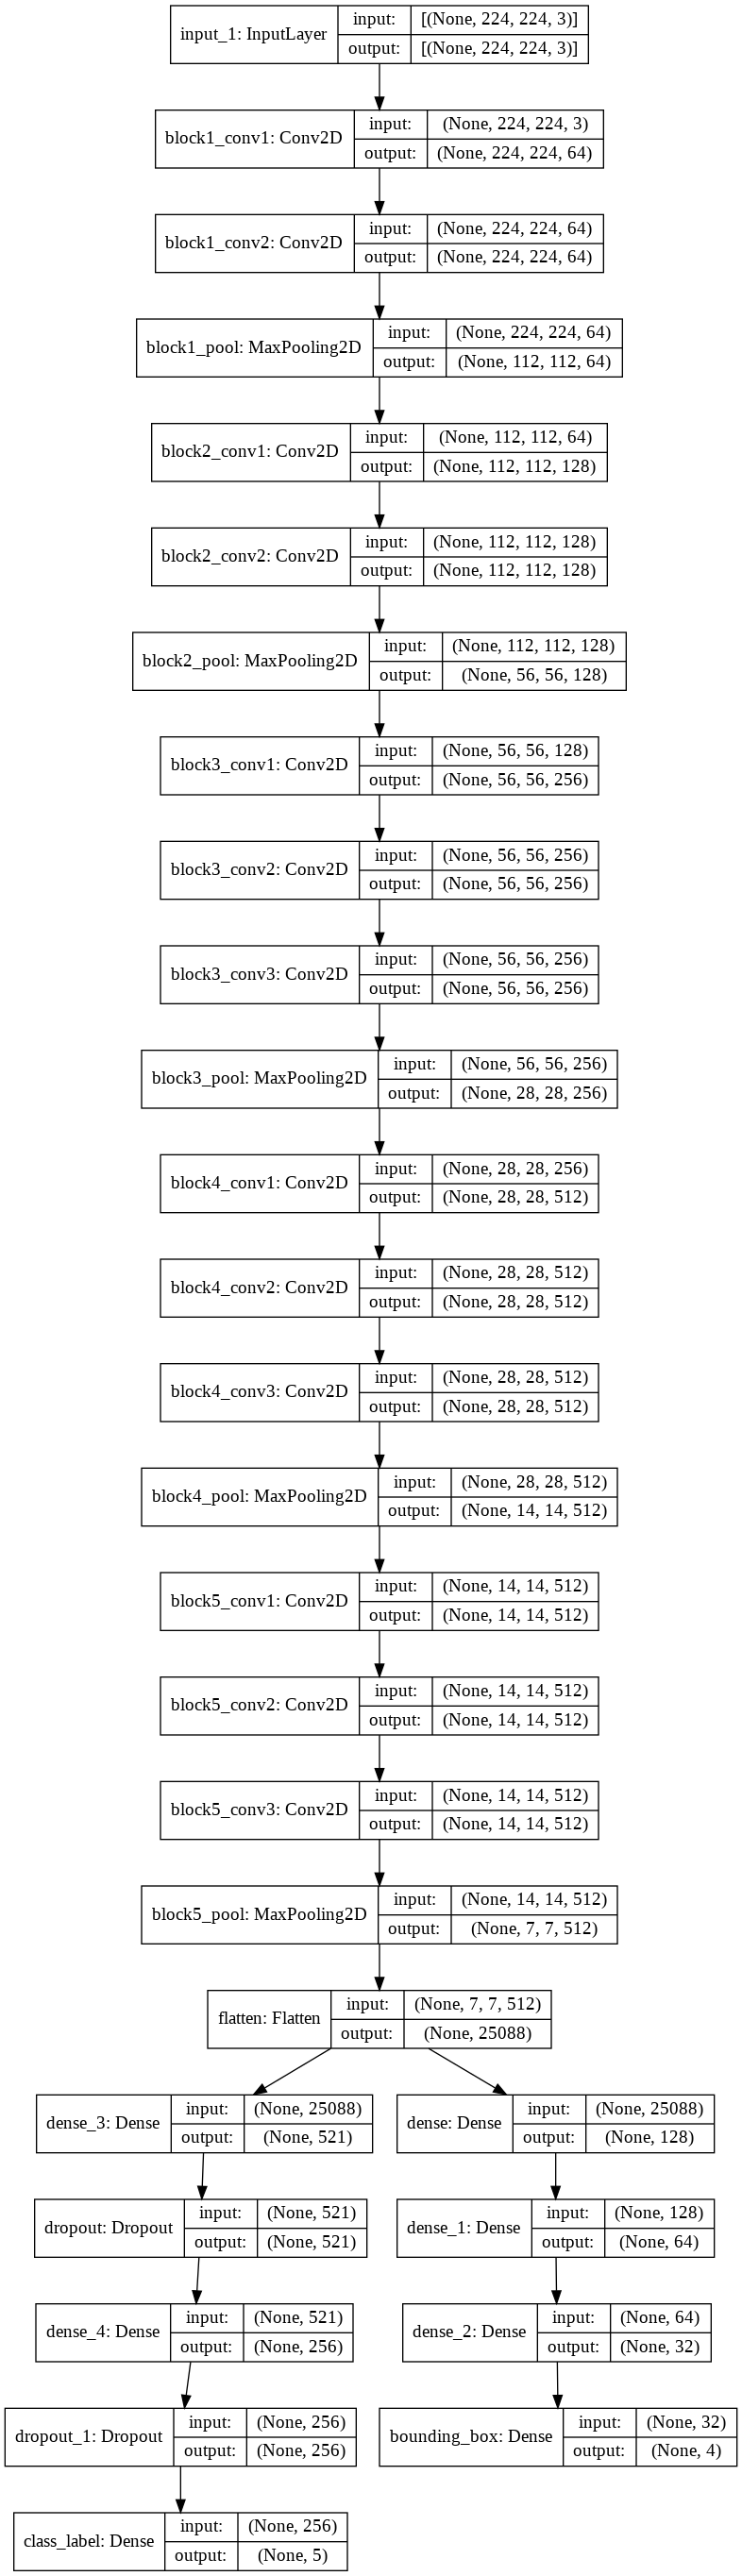

In [43]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=os.path.join(MODEL_PATH, 'model_plot.png'), show_shapes=True, show_layer_names=True)

##5.2 Training

In [44]:
# train the network for bounding box regression and class label prediction
print('Training model...')
H = model.fit(x=X_train, y=[bbox_train, label_train],
              validation_data=(X_valid, [bbox_valid, label_valid]),
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              verbose=1)

# serialize the model to disk
print('Saving object detector model...')
model.save( os.path.join(MODEL_PATH, 'model_detector.h5'), save_format='h5')

Training model...
Epoch 1/25
48/48 [==============================] - 15s 205ms/step - loss: 1.0448 - bounding_box_loss: 0.0372 - class_label_loss: 1.0076 - bounding_box_accuracy: 0.5521 - class_label_accuracy: 0.6567 - val_loss: 0.0483 - val_bounding_box_loss: 0.0036 - val_class_label_loss: 0.0447 - val_bounding_box_accuracy: 0.6309 - val_class_label_accuracy: 0.9921
Epoch 2/25
48/48 [==============================] - 4s 88ms/step - loss: 0.1145 - bounding_box_loss: 0.0028 - class_label_loss: 0.1117 - bounding_box_accuracy: 0.7559 - class_label_accuracy: 0.9643 - val_loss: 0.0195 - val_bounding_box_loss: 0.0022 - val_class_label_loss: 0.0173 - val_bounding_box_accuracy: 0.7984 - val_class_label_accuracy: 0.9974
Epoch 3/25
48/48 [==============================] - 4s 88ms/step - loss: 0.0480 - bounding_box_loss: 0.0015 - class_label_loss: 0.0465 - bounding_box_accuracy: 0.8478 - class_label_accuracy: 0.9825 - val_loss: 0.0121 - val_bounding_box_loss: 0.0019 - val_class_label_loss: 0.010

In [45]:
# serialize the label binarizer to disk
print('Saving label binarizer...')
f = open( os.path.join(MODEL_PATH, 'label_binarizer.pickle'), 'wb')
f.write(pickle.dumps(lb))
f.close()

Saving label binarizer...


In [46]:
for key in H.history.keys():
  print(key)

loss
bounding_box_loss
class_label_loss
bounding_box_accuracy
class_label_accuracy
val_loss
val_bounding_box_loss
val_class_label_loss
val_bounding_box_accuracy
val_class_label_accuracy


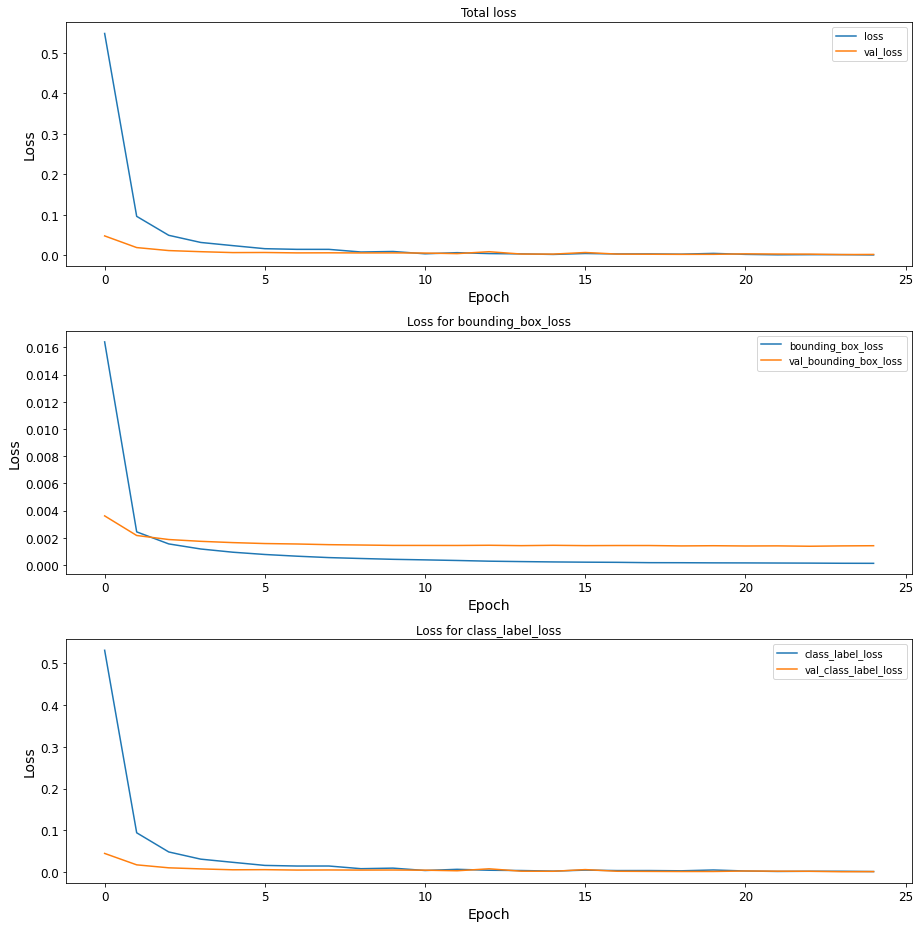

In [47]:
# plot the total loss, label loss, and bounding box loss
loss_names = ['loss', 'bounding_box_loss', 'class_label_loss']

(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, x) in enumerate(loss_names):
	# plot the loss for both the training and validation data
	title = 'Loss for {}'.format(x) if x != 'loss' else 'Total loss'
	ax[i].set_title(title)
	ax[i].set_xlabel('Epoch')
	ax[i].set_ylabel('Loss')
	ax[i].plot(H.history[x], label=x)
	ax[i].plot(H.history['val_' + x], label='val_' + x)
	ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
# plotPath = os.path.sep.join([config.PLOTS_PATH, "losses.png"])
# plt.savefig(plotPath)
plt.show()
plt.close()

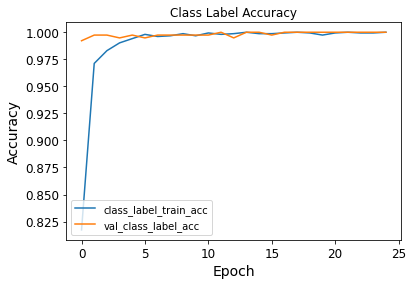

In [48]:
# create a new figure for the accuracies
plt.figure()

plt.plot(H.history['class_label_accuracy'], label='class_label_train_acc')
plt.plot(H.history['val_class_label_accuracy'], label='val_class_label_acc')

plt.title('Class Label Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')

# save the accuracies plot
# plotPath = os.path.sep.join([config.PLOTS_PATH, "accs.png"])
# plt.savefig(plotPath)

plt.show()

##5.3 Predict

In [54]:
imgs_lowercase = [x.lower() for x in imgs_]
imgs_lowercase

['motorbikes', 'airplanes', 'bonsai', 'faces', 'kangaroo']

ID: 0058, Image shape: (300, 233, 3)
ID: 0625, Image shape: (160, 261, 3)
ID: 0201, Image shape: (164, 267, 3)
ID: 0271, Image shape: (142, 264, 3)
ID: 0088, Image shape: (273, 300, 3)
ID: 0046, Image shape: (180, 397, 3)
ID: 0067, Image shape: (351, 532, 3)
ID: 0054, Image shape: (347, 525, 3)
ID: 0615, Image shape: (153, 409, 3)


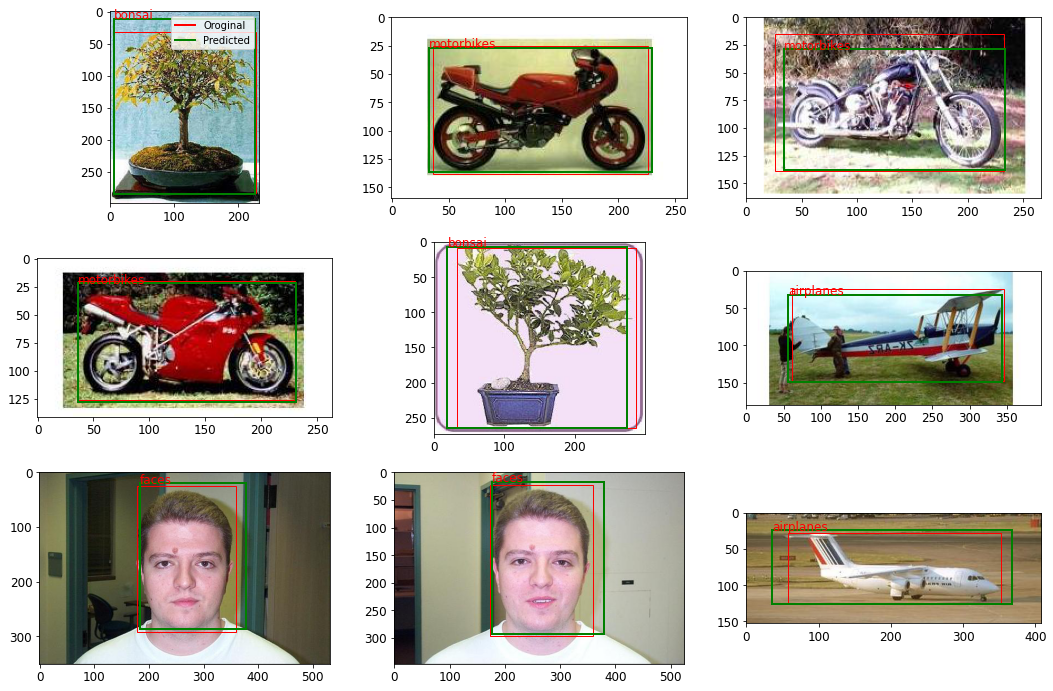

In [66]:
fig, axs = plt.subplots(3, 3, figsize=(18,12))
axs = axs.flatten()

for i in range(9):
  # predict the bounding box of the object along with the class label
  image = X_test[i]
  image = np.expand_dims(image, axis=0)
  bbox_preds, label_preds = model.predict(image)
  (X_start, X_end, Y_start, Y_end) = bbox_preds[0]

  i_class_true  = np.argmax(label_test[i])
  true_class_lb = lb.classes_[i_class_true]
  true_class    = imgs_[ imgs_lowercase.index(true_class_lb) ]
  true_ann      = annots_[imgs_lowercase.index(true_class_lb)]

  # Plot image
  img_path = os.path.join(DATA_PATH, true_class, file_test[i])
  ximg     = Image.open(img_path)
  img_id   = file_test[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  axs[i].imshow(ximg)

  img_shape = np.array(ximg).shape
  print(f'ID: {img_id}, Image shape: {img_shape}')

  ann_file     = os.path.join(ANN_PATH, true_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

  # scale the predicted bounding box coordinates based on the image dimensions
  (h, w)  = img_shape[:2]
  X_start = int(X_start * w)
  Y_start = int(Y_start * h)
  X_end   = int(X_end * w)
  Y_end   = int(Y_end * h)

  rect = patches.Rectangle( (X_start, Y_start), X_end-X_start, Y_end-Y_start, linewidth=2, edgecolor='g', facecolor='none')  
  axs[i].add_patch(rect)

  # determine the class label with the largest predicted probability
  i_class    = np.argmax(label_preds, axis=1)
  pred_label = lb.classes_[i_class][0]
  
  # draw the predicted bounding box and class label on the image
  axs[i].text(X_start, Y_start, str(pred_label), fontsize=12, color='r')

  if i == 0:
    axs[i].plot([0,0],[0,0], 'r-',lw=2, label='Oroginal')
    axs[i].plot([0,0],[0,0], 'g-',lw=2, label='Predicted')

    axs[i].legend()

plt.show()

ID: 0719, Image shape: (144, 402, 3)
ID: 0339, Image shape: (171, 261, 3)
ID: 0057, Image shape: (174, 392, 3)
ID: 0764, Image shape: (138, 398, 3)
ID: 0158, Image shape: (142, 400, 3)
ID: 0021, Image shape: (159, 391, 3)
ID: 0108, Image shape: (282, 300, 3)
ID: 0537, Image shape: (158, 412, 3)
ID: 0375, Image shape: (318, 482, 3)


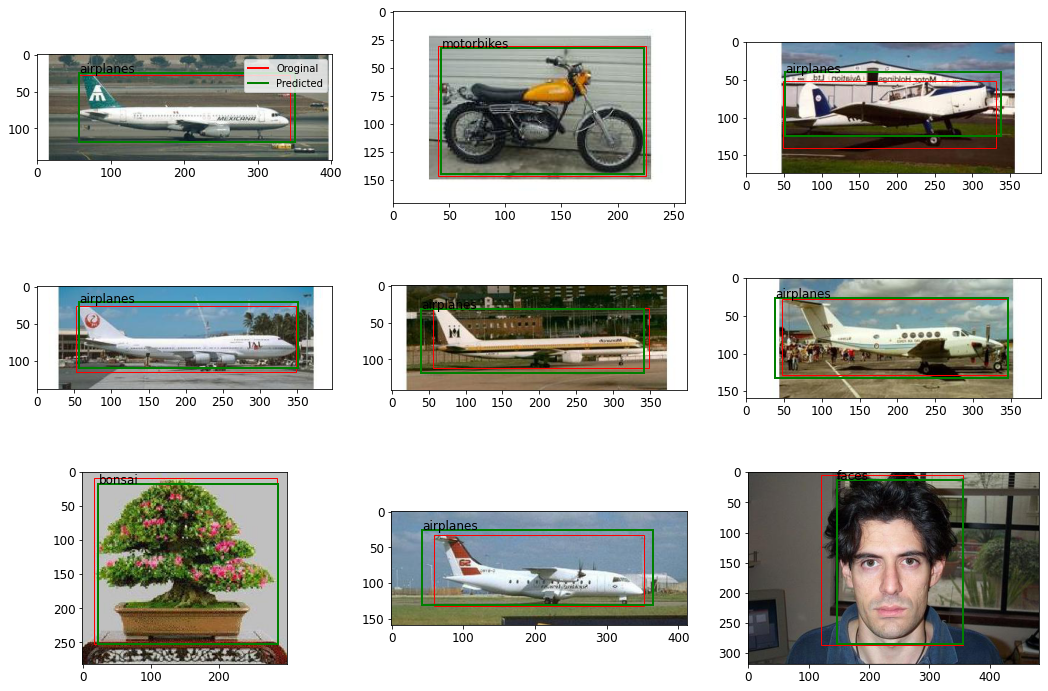

In [68]:
fig, axs = plt.subplots(3, 3, figsize=(18,12))
axs = axs.flatten()

for i in range(9,18):
  # predict the bounding box of the object along with the class label
  image = X_test[i]
  image = np.expand_dims(image, axis=0)
  bbox_preds, label_preds = model.predict(image)
  (X_start, X_end, Y_start, Y_end) = bbox_preds[0]

  i_class_true  = np.argmax(label_test[i])
  true_class_lb = lb.classes_[i_class_true]
  true_class    = imgs_[ imgs_lowercase.index(true_class_lb) ]
  true_ann      = annots_[imgs_lowercase.index(true_class_lb)]

  # Plot image
  img_path = os.path.join(DATA_PATH, true_class, file_test[i])
  ximg     = Image.open(img_path)
  img_id   = file_test[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  axs[i-9].imshow(ximg)

  img_shape = np.array(ximg).shape
  print(f'ID: {img_id}, Image shape: {img_shape}')

  ann_file     = os.path.join(ANN_PATH, true_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i-9].add_patch(rect)

  # scale the predicted bounding box coordinates based on the image dimensions
  (h, w)  = img_shape[:2]
  X_start = int(X_start * w)
  Y_start = int(Y_start * h)
  X_end   = int(X_end * w)
  Y_end   = int(Y_end * h)

  rect = patches.Rectangle( (X_start, Y_start), X_end-X_start, Y_end-Y_start, linewidth=2, edgecolor='g', facecolor='none')  
  axs[i-9].add_patch(rect)

  # determine the class label with the largest predicted probability
  i_class    = np.argmax(label_preds, axis=1)
  pred_label = lb.classes_[i_class][0]
  
  # draw the predicted bounding box and class label on the image
  axs[i-9].text(X_start, Y_start, str(pred_label), fontsize=12)

  if i-9 == 0:
    axs[i-9].plot([0,0],[0,0], 'r-',lw=2, label='Oroginal')
    axs[i-9].plot([0,0],[0,0], 'g-',lw=2, label='Predicted')

    axs[i-9].legend()

plt.show()